# Identify potential SNIa detected at early times

Authors: Melissa Graham

Look for potential SNIa that might have been caught early and assess how many, how early, and
whether the individual-exposure light curves reveal an intra-night rise.

Since any early-caught SNIa would also be at lower redshift, approach this by looking for
candidates that were identified as potential SNIa, which were first detected well before peak brightness  
OR reached a peak brightness of <21 mag OR are cross-matched with a <0.2 galaxy.

## Set up and read in data

Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sncosmo
import iminuit

A bit of set up to re-run sncosmo.

In [2]:
model = sncosmo.Model(source='salt2')
zeropoint = 31.4
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Set light curve plot parameters

In [3]:
clr = ['darkgreen', 'firebrick', 'saddlebrown', 'limegreen', 'orange', 'lightcoral']

all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','^']
all_fsizes  = [5, 5, 7]

Read in the list of potential SNIa candidates.

In [4]:
potSNIa_candid = np.loadtxt('potential_snia_list.dat', dtype='str', usecols=(0))

Read in the nightly epoch light curves for all candidates.

In [5]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Read in the parameters for the nightly epoch light curves for all candidates.

In [6]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt( fnm, dtype='str', usecols=(0) )
paramLC_candid = np.loadtxt( fnm, dtype='str', usecols=(1) )
paramLC_tspan = np.loadtxt( fnm, dtype='float', usecols=(2) )
paramLC_tspan_g = np.loadtxt( fnm, dtype='float', usecols=(3) )
paramLC_tspan_r = np.loadtxt( fnm, dtype='float', usecols=(4) )
paramLC_tspan_i = np.loadtxt( fnm, dtype='float', usecols=(5) )
paramLC_minmag = np.loadtxt( fnm, dtype='float', usecols=(6) )
paramLC_minmag_g = np.loadtxt( fnm, dtype='float', usecols=(7) )
paramLC_minmag_r = np.loadtxt( fnm, dtype='float', usecols=(8) )
paramLC_minmag_i = np.loadtxt( fnm, dtype='float', usecols=(9) )
paramLC_amp = np.loadtxt( fnm, dtype='float', usecols=(10) )
paramLC_amp_g = np.loadtxt( fnm, dtype='float', usecols=(11) )
paramLC_amp_r = np.loadtxt( fnm, dtype='float', usecols=(12) )
paramLC_amp_i = np.loadtxt( fnm, dtype='float', usecols=(13) )
paramLC_neps = np.loadtxt( fnm, dtype='int', usecols=(14) )
paramLC_neps_g = np.loadtxt( fnm, dtype='int', usecols=(15) )
paramLC_neps_r = np.loadtxt( fnm, dtype='int', usecols=(16) )
paramLC_neps_i = np.loadtxt( fnm, dtype='int', usecols=(17) )
del fnm

Read in the `sncosmo` results.

In [7]:
fnm = '2_all_potential_snia_fits/results_sncosmos.dat'
fit_cand = np.loadtxt(fnm, dtype='str', usecols=(0))
fit_est_z = np.loadtxt(fnm, dtype='float', usecols=(1))
fit_in_zlo = np.loadtxt(fnm, dtype='float', usecols=(2))
fit_in_zhi = np.loadtxt(fnm, dtype='float', usecols=(3))
fit_z = np.loadtxt(fnm, dtype='float', usecols=(4))
fit_ze = np.loadtxt(fnm, dtype='float', usecols=(5))
fit_t0 = np.loadtxt(fnm, dtype='float', usecols=(6))
fit_t0e = np.loadtxt(fnm, dtype='float', usecols=(7))
fit_x0 = np.loadtxt(fnm, dtype='float', usecols=(8))
fit_x0e = np.loadtxt(fnm, dtype='float', usecols=(9))
fit_x1 = np.loadtxt(fnm, dtype='float', usecols=(10))
fit_x1e = np.loadtxt(fnm, dtype='float', usecols=(11))
fit_c = np.loadtxt(fnm, dtype='float', usecols=(12))
fit_ce = np.loadtxt(fnm, dtype='float', usecols=(13))
fit_pmB = np.loadtxt(fnm, dtype='float', usecols=(14))
fit_pmg = np.loadtxt(fnm, dtype='float', usecols=(15))
fit_pmr = np.loadtxt(fnm, dtype='float', usecols=(16))
fit_pmi = np.loadtxt(fnm, dtype='float', usecols=(17))
del fnm

Read in MLG's flags. Create `fit_mlgflag` for the `fit_` arrays to hold the flag value.

In [8]:
fnm = '2_all_potential_snia_fits/MLG_review_ratings.txt'
mlg_review_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
mlg_review_flag = np.loadtxt(fnm, dtype='int', usecols=(1))
del fnm

fit_mlgflag = np.zeros(len(fit_cand), dtype='int') - 1
for c, candid in enumerate(fit_cand):
    tx = np.where(candid == mlg_review_candid)[0]
    if len(tx) == 1:
        fit_mlgflag[c] = mlg_review_flag[tx[0]]
    del tx

del mlg_review_candid, mlg_review_flag

Read in the cross-match data.

In [9]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_candra   = np.loadtxt(fnm, dtype='float', usecols=(1))
lsdr10xm_canddec  = np.loadtxt(fnm, dtype='float', usecols=(2))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_sep      = np.loadtxt(fnm, dtype='float', usecols=(7))
lsdr10xm_ra       = np.loadtxt(fnm, dtype='float', usecols=(8))
lsdr10xm_dec      = np.loadtxt(fnm, dtype='float', usecols=(9))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
lsdr10xm_type     = np.loadtxt(fnm, dtype='str', usecols=(15))
lsdr10xm_shaper   = np.loadtxt(fnm, dtype='float', usecols=(19))
lsdr10xm_rpsfsize = np.loadtxt(fnm, dtype='float', usecols=(21))  
lsdr10xm_meanpz   = np.loadtxt(fnm, dtype='float', usecols=(23))
lsdr10xm_stdpz    = np.loadtxt(fnm, dtype='float', usecols=(24))
lsdr10xm_specz    = np.loadtxt(fnm, dtype='float', usecols=(25))
del fnm

For every potential SNIa store its index in the `fit_` arrays 
as `findex` for the `lsdr10xm_` arrays.

In [10]:
lsdr10xm_findex = np.zeros(len(lsdr10xm_candid), dtype='int')-1

for cid in potSNIa_candid:
    tx = np.where(lsdr10xm_candid == cid)[0]
    if len(tx) == 1:
        ttx = np.where(fit_cand == cid)[0]
        if len(ttx) == 1:
            lsdr10xm_findex[tx[0]] = ttx[0]
        del ttx
    del tx

For every candidate that was fit, store its index in the `lsdr10xm_` arrays as `fit_xmindex`.

In [11]:
fit_xmindex = np.zeros(len(fit_cand), dtype='int') -1

for c, cand in enumerate(fit_cand):
    tx = np.where(lsdr10xm_candid == cand)[0]
    fit_xmindex[c] = tx[0]
    del tx
    
tx = np.where(fit_xmindex >= 0)[0]
print(len(tx), ' should equal ', len(fit_cand))

100  should equal  100


## Identify potential SNIa of interest

Make a merged list of candidates that were identified as potential SNIa, and at least on of the following.

1. First epoch of detection was 28-14 days before time of peak brightness.
2. Peak apparent brightness was <= 21 magnitude in any filter.
3. Cross-matched with a galaxy with photo-z <= 0.2.

### Detected 28 to 14 days before peak brightness

SNIa light curves are known to have rise times around 20 days, plus or minus a few days.
Then, there is also the fact that higher-redshift SNIa will exhibit cosmological
time dilation which 'stretches' them by a few days at z=0.2 (i.e., by a factor of 1+z). 

https://arxiv.org/abs/1411.1064

https://ui.adsabs.harvard.edu/abs/1999AJ....118.2675R/abstract

Do not include "lonely epochs" in this tally. 

Do use the sncosmo fit peak date to estimate the rise time.

Below, the date of brightest observation is also used to calculate a second rise time,
but on inspection this was not as accurate in every case where the second rise time
fit between the min and max days, but the first (the sncosmo one) did not.
So we don't actually use the second rise time for the analysis.

In [12]:
rise_min = 14
rise_max = 28

fit_interest_flag_1 = np.zeros(len(fit_cand), dtype='int')
fit_rise_1 = np.zeros(len(fit_cand), dtype='float')
fit_rise_2 = np.zeros(len(fit_cand), dtype='float')

for c, cand in enumerate(fit_cand):
    if fit_t0[c] > 0.0:
        date_peak_1 = fit_t0[c]
        cx = np.where((candLC_candid == cand) & (candLC_lef == 0))[0]
        mx = np.argmin(candLC_mag[cx])
        date_peak_2 = candLC_mjd[cx[mx]]
        date_first = np.min(candLC_mjd[cx])
        fit_rise_1[c] = date_peak_1 - date_first
        fit_rise_2[c] = date_peak_2 - date_first
        
        if (fit_mlgflag[c] == 0) & (fit_rise_1[c] >= rise_min) & (fit_rise_1[c] < rise_max):
            print('1 %10s %4.1f %4.1f %1i %4.1f %4.2f' % 
                  (cand, fit_rise_1[c], fit_rise_2[c], fit_mlgflag[c], fit_pmB[c], fit_z[c]))
            fit_interest_flag_1[c] = 1
        # else:
        #     if (fit_mlgflag[c] == 0) & (fit_rise_2[c] >= rise_min) & (fit_rise_2[c] < rise_max):
        #         print('2 %10s %4.1f %4.1f %1i' % 
        #               (cand, fit_rise_1[c], fit_rise_2[c], fit_mlgflag[c]))
        #         fit_interest_flag_1[c] = 1
                
        del date_peak_1, date_peak_2
        del cx, mx

tx = np.where(fit_interest_flag_1 == 1)[0]
print('total = ', len(tx))
del tx
tx = np.where(fit_mlgflag == 0)[0]
print('out of ', len(tx), ' unflagged potential SNIa')
del tx

1   DC21bkrj 14.6 15.0 0 21.2 0.13
1  DC21cwtlp 15.4 12.0 0 22.5 0.39
1  DC21cwtvj 14.9 17.9 0 21.9 0.28
1  DC21cwxin 16.4 17.9 0 21.4 0.37
1  DC21cyddn 14.4 14.9 0 21.9 0.21
1   DC21dhgr 14.7 12.0 0 21.3 0.27
1   DC21dqik 19.4 33.1 0 20.9 0.26
1  DC21dsocp 14.2 11.9 0 20.3 0.14
1   DC21esjb 14.2 12.0 0 22.1 0.37
1   DC21fber 15.7 15.0 0 21.8 0.27
1  DC22gwmgv 15.3 19.9 0 22.0 0.30
1  DC22hvtwp 14.0 14.0 0 21.3 0.16
1  DC22hxfom 14.0 12.0 0 21.9 0.32
1  DC22iykha 17.6 15.1 0 19.6 0.15
1  DC23jwnzq 14.9 10.0 0 21.7 0.29
1  DC23kpigs 15.8 17.9 0 21.4 0.21
1  DC23kwpaw 16.5 19.0 0 21.9 0.28
total =  17
out of  34  unflagged potential SNIa


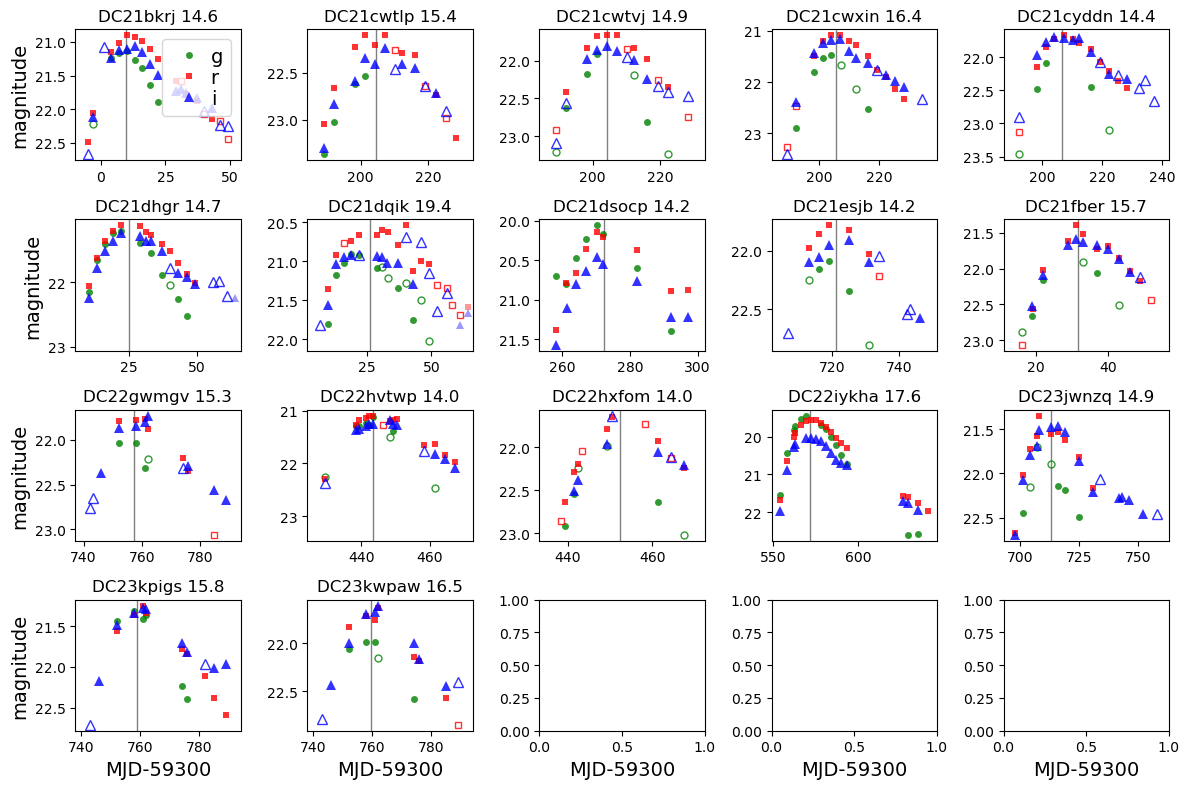

In [14]:
tx = np.where(fit_interest_flag_1 == 1)[0]

nrow = 4
ncol = 5
fig, ax = plt.subplots( nrow, ncol, figsize=(12, 8), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncol):
        if x < len(tx):
            ax[i, j].axvline(fit_t0[tx[x]]-59300., lw=1, color='grey')
            for f,filt in enumerate(all_filters):
                cx0 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
                cx1 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
                cx2 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
                ax[i, j].plot(candLC_mjd[cx0]-59300., candLC_mag[cx0], 
                             all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
                ax[i, j].plot(candLC_mjd[cx1]-59300., candLC_mag[cx1], 
                             all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
                ax[i, j].plot(candLC_mjd[cx2]-59300., candLC_mag[cx2], 
                             all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
                del cx0, cx1, cx2

            cx = np.where((candLC_candid == fit_cand[tx[x]]) & (candLC_lef == 0))[0]
            xmin = np.min(candLC_mjd[cx])
            xmax = np.max(candLC_mjd[cx])
            del cx
            ax[i, j].invert_yaxis()
            ax[i, j].set_xlim([xmin-59300.-5, xmax-59300.+5])
            del xmin, xmax
            ax[i, j].set_title(fit_cand[tx[x]] + ' ' +
                               str(np.round(fit_rise_1[tx[x]], 1)))
            x += 1

ax[0, 0].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD-59300', fontsize=14)

plt.tight_layout()
plt.show()
del tx, x

### Peak brightness <= 21 mag

At redshift 0.2, the luminosity distance is ~1000 Mpc and the distance modulus is ~40 mag.
So for SNIa that peak around -19 to -19.3, the apparent peak is around 21 mag.
These objects should be detectable in their early days, if they're SNIa.

In [15]:
peak_max = 21.0
fit_interest_flag_2 = np.zeros(len(fit_cand), dtype='int')

for c, cand in enumerate(fit_cand):
    cx = np.where((candLC_candid == cand) & (candLC_lef == 0))[0]
    min_mag = np.min(candLC_mag[cx])
    
    if (fit_mlgflag[c] == 0) & \
    ((min_mag <= peak_max) | (fit_pmB[c] <= peak_max) | \
     (fit_pmg[c] <= peak_max) | (fit_pmr[c] <= peak_max) | \
     (fit_pmi[c] <= peak_max)):
        
        print('%10s %4.1f %4.1f %4.1f %4.1f %4.1f %1i' % 
              (cand, min_mag, fit_pmB[c], fit_pmg[c], fit_pmr[c], fit_pmi[c], fit_mlgflag[c]))
        fit_interest_flag_2[c] = 1
    
    del cx, min_mag

tx = np.where(fit_interest_flag_2 == 1)[0]
print('total = ', len(tx))
del tx

  DC21bkrj 20.9 21.2 21.2 21.0 21.5 0
 DC21dpwcq 20.5 20.8 20.8 20.7 21.2 0
  DC21dqik 20.5 20.9 21.0 21.2 21.6 0
 DC21dqpcm 20.5 20.6 20.7 20.8 21.4 0
 DC21dsocp 20.1 20.3 20.3 20.4 21.0 0
 DC22gtpdx 19.1 21.6 21.7 21.6 22.1 0
 DC22hxfpz 20.6 21.0 21.0 21.1 21.7 0
 DC22iykha 19.4 19.6 19.7 19.9 20.6 0
 DC23jxtzq 20.8 21.4 21.4 21.5 22.1 0
total =  9


In [16]:
tx = np.where((fit_interest_flag_1 == 1) & (fit_interest_flag_2 == 1))[0]
print('also had rise time of interest: ', len(tx))
for x in tx:
    print(fit_cand[x], fit_mlgflag[x])
del tx

also had rise time of interest:  4
DC21bkrj 0
DC21dqik 0
DC21dsocp 0
DC22iykha 0


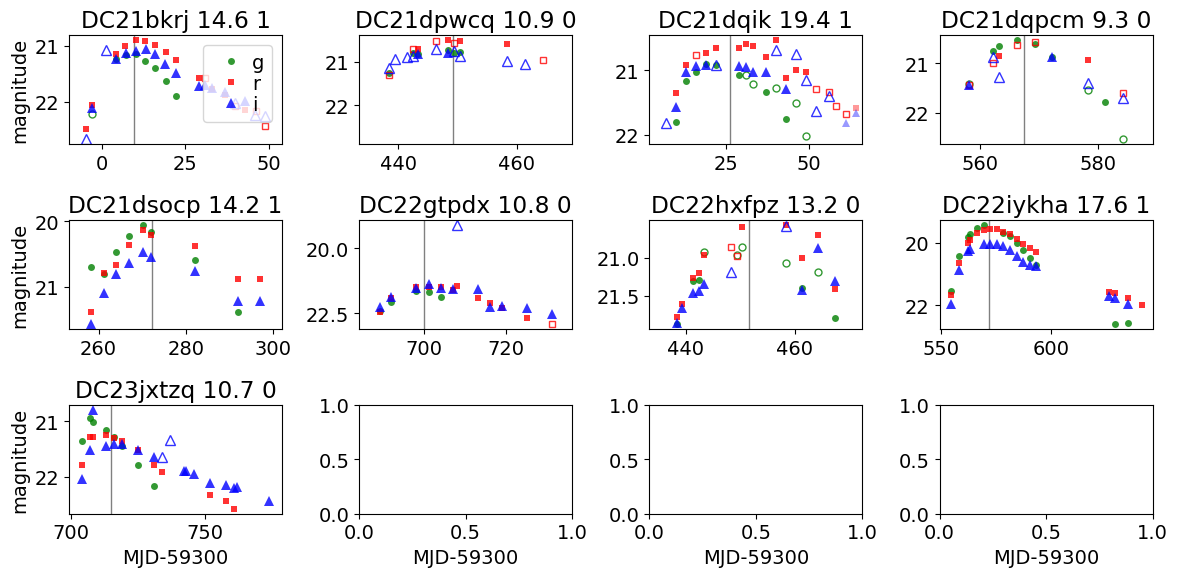

In [25]:
tx = np.where(fit_interest_flag_2 == 1)[0]

nrow = 3
ncol = 4
fig, ax = plt.subplots( nrow, ncol, figsize=(12, 6), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncol):
        if x < len(tx):
            ax[i, j].axvline(fit_t0[tx[x]]-59300., lw=1, color='grey')
            for f,filt in enumerate(all_filters):
                cx0 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
                cx1 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
                cx2 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
                ax[i, j].plot(candLC_mjd[cx0]-59300., candLC_mag[cx0], 
                             all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
                ax[i, j].plot(candLC_mjd[cx1]-59300., candLC_mag[cx1], 
                             all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
                ax[i, j].plot(candLC_mjd[cx2]-59300., candLC_mag[cx2], 
                             all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
                del cx0, cx1, cx2

            cx = np.where((candLC_candid == fit_cand[tx[x]]) & (candLC_lef == 0))[0]
            xmin = np.min(candLC_mjd[cx])
            xmax = np.max(candLC_mjd[cx])
            del cx
            ax[i, j].invert_yaxis()
            ax[i, j].set_xlim([xmin-59300.-5, xmax-59300.+5])
            del xmin, xmax
            ax[i, j].set_title(fit_cand[tx[x]] + ' ' +
                               str(np.round(fit_rise_1[tx[x]], 1)) + ' ' + 
                               str(fit_interest_flag_1[tx[x]]))
            x += 1

ax[0, 0].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD-59300', fontsize=14)

plt.tight_layout()
plt.show()
del tx, x

### Cross-matched with a z <= 0.2 galaxy

Recall that candidates cross-matched to a galaxy have `flagstar` = 0.

In [18]:
fit_interest_flag_3 = np.zeros(len(fit_cand), dtype='int')
tx = np.where((fit_mlgflag == 0) 
              & (lsdr10xm_flagstar[fit_xmindex] == 0)
              & (lsdr10xm_meanpz[fit_xmindex] > 0.0)
              & (lsdr10xm_meanpz[fit_xmindex] <= 0.2))[0]
fit_interest_flag_3[tx] = 1
del tx

for c, cand in enumerate(fit_cand):
    if fit_interest_flag_3[c] == 1:
        print('%10s %1i %4.2f %1i' % 
              (cand, lsdr10xm_flagstar[fit_xmindex[c]], lsdr10xm_meanpz[fit_xmindex[c]], fit_mlgflag[c]))

tx = np.where(fit_interest_flag_3 == 1)[0]
print('total = ', len(tx))
del tx

 DC21cwxin 0 0.17 0
 DC21dpwcq 0 0.19 0
 DC21dqpcm 0 0.18 0
 DC21dsocp 0 0.17 0
total =  4


In [19]:
tx = np.where((fit_interest_flag_1 == 1) 
              & (fit_interest_flag_3 == 1))[0]
print('also had rise time of interest: ', len(tx))
for x in tx:
    print(fit_cand[x], fit_mlgflag[x])
del tx

also had rise time of interest:  2
DC21cwxin 0
DC21dsocp 0


In [20]:
tx = np.where((fit_interest_flag_1 == 1) 
              & (fit_interest_flag_2 == 1) 
              & (fit_interest_flag_3 == 1))[0]
print('also had rise time of interest AND peak <= 21: ', len(tx))
for x in tx:
    print(fit_cand[x], fit_mlgflag[x])
del tx

also had rise time of interest AND peak <= 21:  1
DC21dsocp 0


In [27]:
tx = np.where(fit_cand == 'DC21dsocp')[0]
print('xmatch pz = ', lsdr10xm_meanpz[fit_xmindex[tx[0]]])
print('rmag = ', lsdr10xm_rmag[fit_xmindex[tx[0]]])

xmatch pz =  0.1732
rmag =  21.387


This is lazy but, just have an empty row so as to not have to recode the axis from two to one dimension.

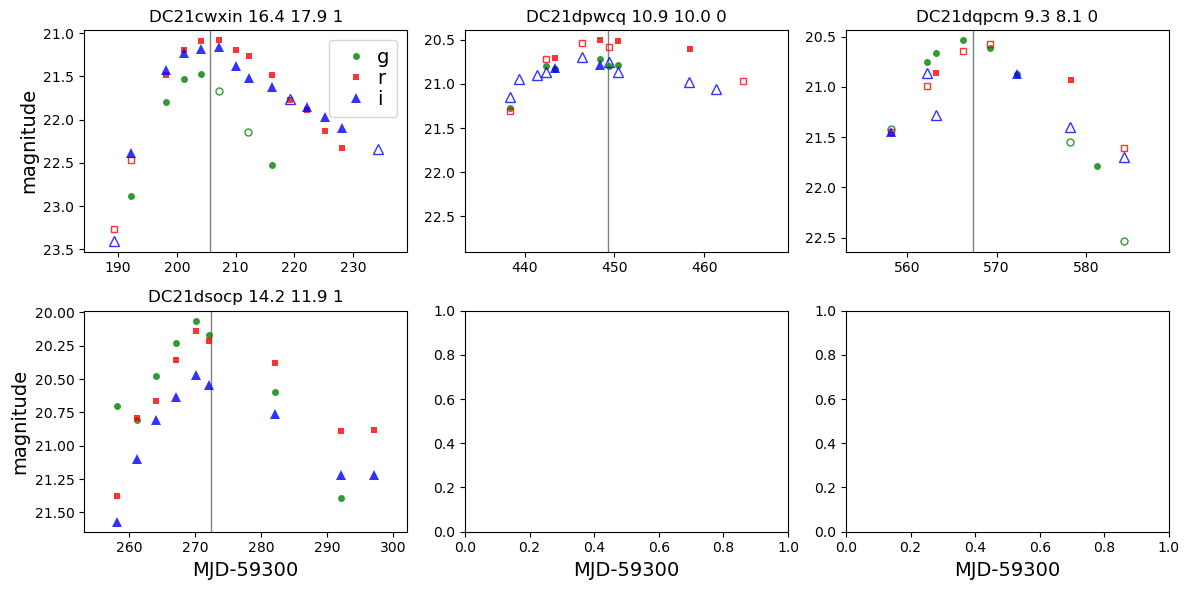

In [21]:
tx = np.where(fit_interest_flag_3 == 1)[0]

nrow = 2
ncol = 3
fig, ax = plt.subplots( nrow, ncol, figsize=(12, 6), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncol):
        if x < len(tx):
            ax[i, j].axvline(fit_t0[tx[x]]-59300., lw=1, color='grey')
            for f,filt in enumerate(all_filters):
                cx0 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
                cx1 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
                cx2 = np.where((candLC_candid == fit_cand[tx[x]]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
                ax[i, j].plot(candLC_mjd[cx0]-59300., candLC_mag[cx0], 
                             all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
                ax[i, j].plot(candLC_mjd[cx1]-59300., candLC_mag[cx1], 
                             all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
                ax[i, j].plot(candLC_mjd[cx2]-59300., candLC_mag[cx2], 
                             all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
                del cx0, cx1, cx2

            cx = np.where((candLC_candid == fit_cand[tx[x]]) & (candLC_lef == 0))[0]
            xmin = np.min(candLC_mjd[cx])
            xmax = np.max(candLC_mjd[cx])
            del cx
            ax[i, j].invert_yaxis()
            ax[i, j].set_xlim([xmin-59300.-5, xmax-59300.+5])
            del xmin, xmax
            ax[i, j].set_title(fit_cand[tx[x]] + ' ' +
                               str(np.round(fit_rise_1[tx[x]], 1)) + ' ' + 
                               str(np.round(fit_rise_2[tx[x]], 1)) + ' ' + 
                               str(fit_interest_flag_1[tx[x]]))
            x += 1

ax[0, 0].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD-59300', fontsize=14)

plt.tight_layout()
plt.show()
del tx, x

## Early time rise detected?

To take a closer look at whether an early time rise was detected
requires access to the photometry from the individual difference images.

(Continue in notebook 5a).

## Deviations from template light curve at early time?

Redo the sncomos fit in order to over-plot it on the photometry points.

Would maybe make more sense to leave out the first epoch and then refit.

But generally the early-time detections aren't densly sampled enough anyway.

Do this for all of the candidates identified as "interesting" based on rise time.

Look for early epochs that are bluer/brighter than the sncosmos fit.

In [22]:
tx = np.where(fit_interest_flag_1 == 1)[0]
my_cands_list = fit_cand[tx]
print(my_cands_list)

['DC21bkrj' 'DC21cwtlp' 'DC21cwtvj' 'DC21cwxin' 'DC21cyddn' 'DC21dhgr'
 'DC21dqik' 'DC21dsocp' 'DC21esjb' 'DC21fber' 'DC22gwmgv' 'DC22hvtwp'
 'DC22hxfom' 'DC22iykha' 'DC23jwnzq' 'DC23kpigs' 'DC23kwpaw']


In [23]:
foffset = np.asarray([-0.5, 0.0, +0.5], dtype='float')

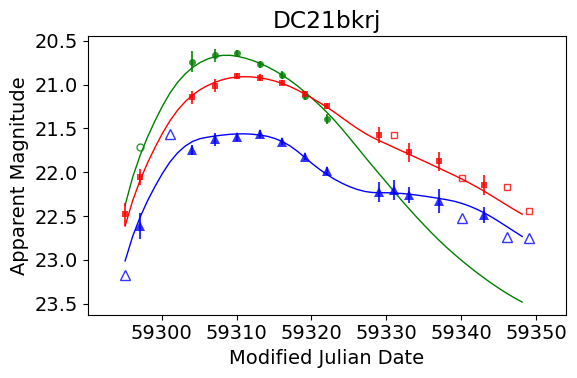

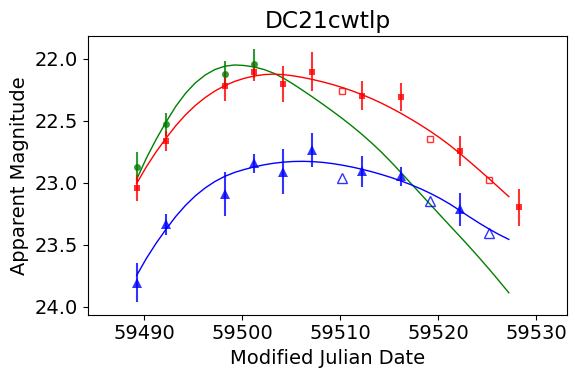

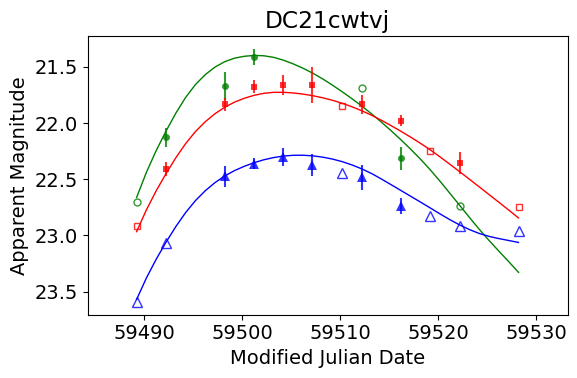

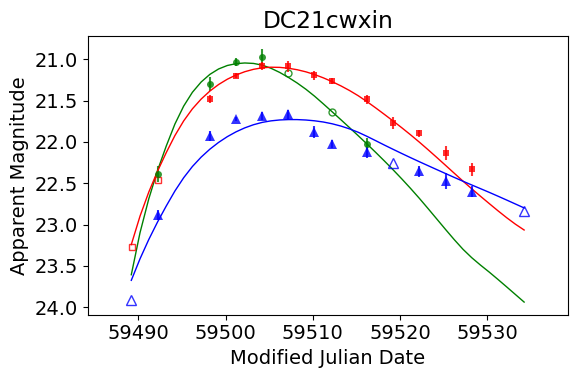

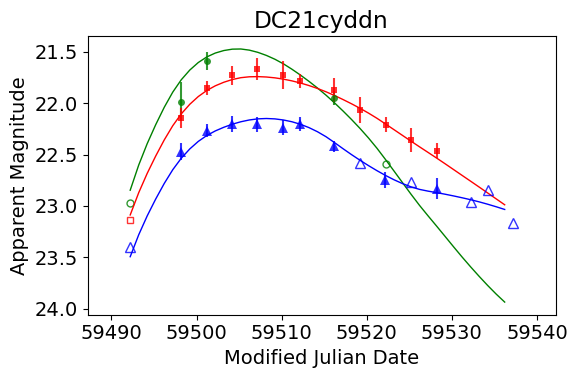

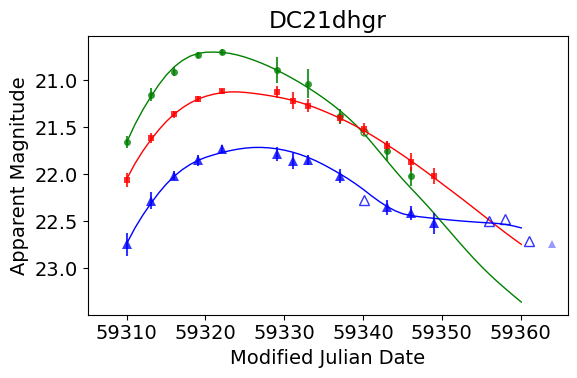

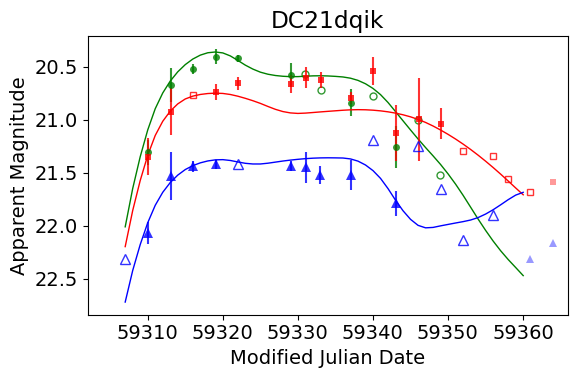

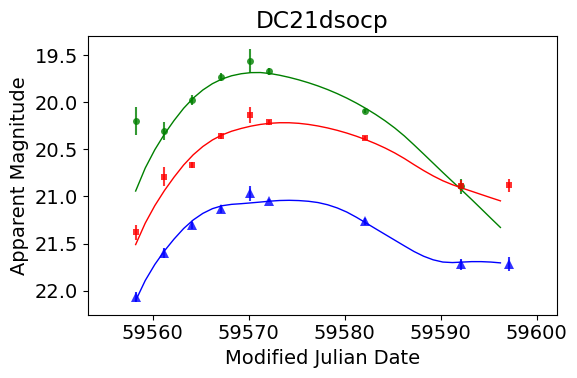

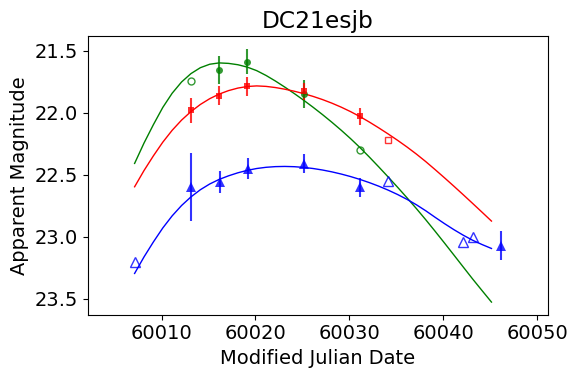

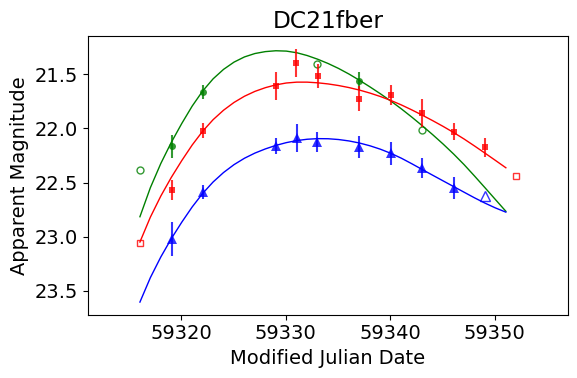

60042.144339 60089.006719


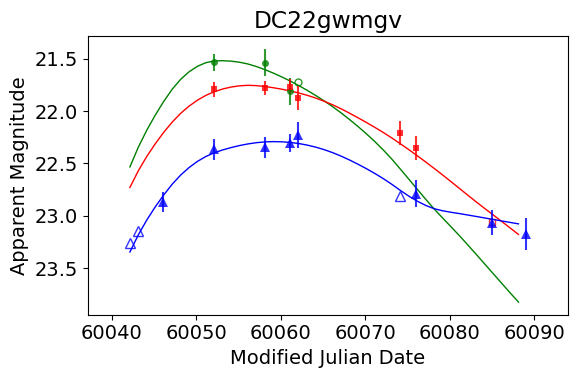

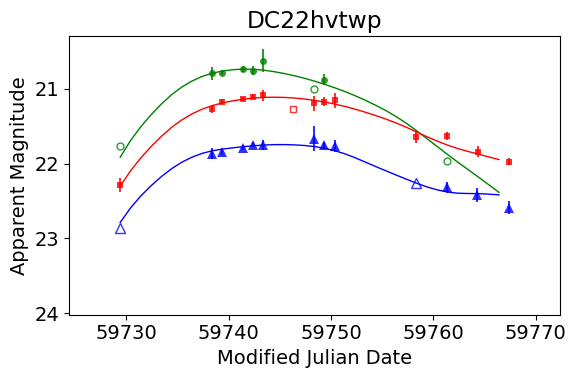

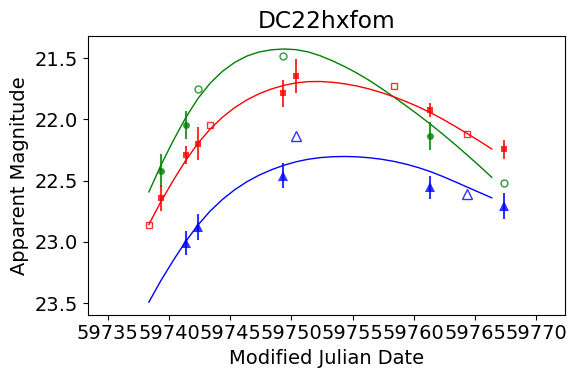

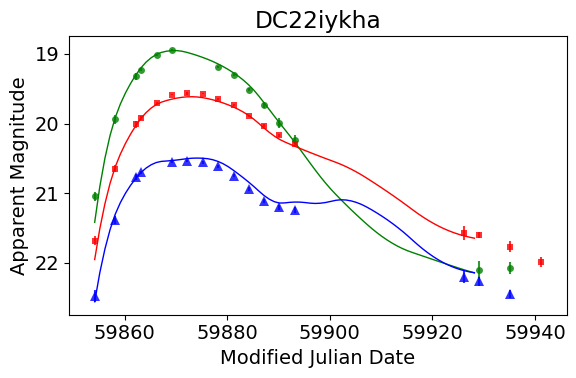

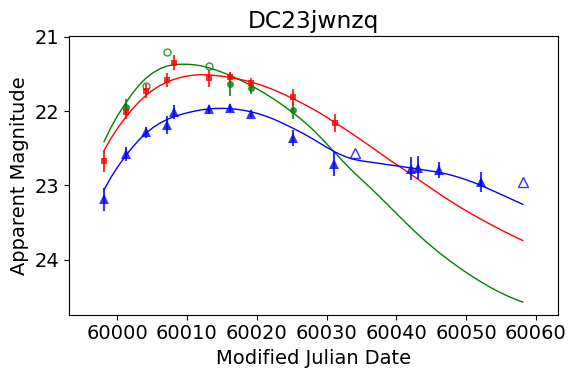

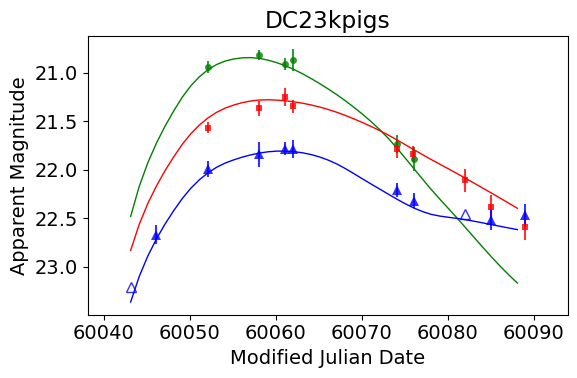

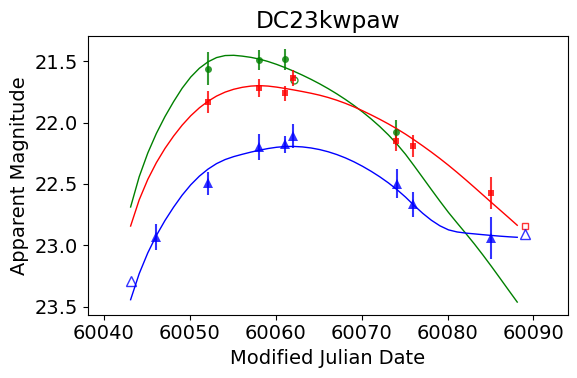

In [24]:
for use_candidate in my_cands_list:

    px = np.where((candLC_candid == use_candidate) & (candLC_lef == 0))[0]
    fout = open('temp_sncosmo.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    for x in px:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - zeropoint)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - zeropoint)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f %5.1f ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe, zeropoint))
    fout.close()
    del px

    data = sncosmo.read_lc('temp_sncosmo.txt')

    cx = np.where(fit_cand == use_candidate)[0]
    result, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'x0', 'x1', 'c'], 
                                          bounds={'z':(fit_in_zlo[cx[0]], fit_in_zhi[cx[0]])})
    del cx

    fig = plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 14})

    px = np.where((candLC_candid == use_candidate) & (candLC_lef == 0))[0]
    xmin = np.min(candLC_mjd[px])
    xmax = np.max(candLC_mjd[px])
    if use_candidate == 'DC21dtwb':
        xmax = 59360
    if use_candidate == 'DC22gwmgv':
        print(xmin, xmax)
    del px

    fit_x = np.arange(np.ceil(xmax-xmin), dtype='float') + xmin

    for f, filt in enumerate(all_filters):
        cx0 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                       (candLC_mrb > 0.4))[0]
        cx1 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                       (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
        cx2 = np.where((candLC_candid == use_candidate) & (candLC_filter == filt) & 
                       (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
        if(len(cx0) > 0):
            # plt.plot(candLC_mjd[cx0], candLC_mag[cx0], all_fshapes[f], ms=all_fsizes[f], 
            #          mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
            plt.errorbar(candLC_mjd[cx0], candLC_mag[cx0]+foffset[f], yerr=candLC_mage[cx0],
                         fmt=all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
        if(len(cx1) > 0):
            plt.plot(candLC_mjd[cx1], candLC_mag[cx1]+foffset[f], all_fshapes[f], ms=all_fsizes[f], 
                     mew=1, alpha=0.8, color='none', mec=all_fcolors[f], label=filt+' (R/B<0.4)')
        if(len(cx2) > 0):
            plt.plot(candLC_mjd[cx2], candLC_mag[cx2]+foffset[f], all_fshapes[f], ms=all_fsizes[f]-1, 
                     mew=0, alpha=0.4, color=all_fcolors[f])
        del cx0, cx1, cx2

        sdss_band = 'sdss' + filt
        fit_m = np.zeros(len(fit_x), dtype='float')
        for x, day in enumerate(fit_x):
            fit_m[x] = fitted_model.bandmag(sdss_band, 'ab', day)
        plt.plot(fit_x, fit_m+foffset[f], lw=1, color=all_fcolors[f])
        del fit_m

    plt.gca().invert_yaxis()
    plt.title(use_candidate)
    # plt.legend(loc='best', labelspacing=0.1, handletextpad=0.1, fontsize=14)
    plt.xlim([xmin - 5.0, xmax + 5.0])
    del xmin, xmax

    plt.xlabel('Modified Julian Date', fontsize=14)
    plt.ylabel('Apparent Magnitude', fontsize=14)

    fig.tight_layout()
    plt.show()